In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from src.autoencoder import Autoencoder, VariationalAutoEncoder
from utils.mnist_loader import data_download, data_loader
from utils.model_trainer import autoencoder_trainer
from utils.visualization import visualization

In [4]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
EPOCHS = 20
print(DEVICE)
train_data, test_data = data_download()
train_loader, test_loader = data_loader(train_data, test_data, batch_size=256)

cuda
number of training data :  60000
number of test data :  10000


# Autoencoder

In [6]:
model=Autoencoder(n_hidden=256).to(DEVICE)
criteria = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [7]:
train_loss, test_loss = autoencoder_trainer(model=model, 
                                            criteria=criteria, optimizer=optimizer, 
                                            train_loader=train_loader, test_loader=test_loader, 
                                            device=DEVICE, epochs = EPOCHS)

  5%|▌         | 1/20 [00:52<16:35, 52.41s/it]

epochs: 1 - Train error: 0.1481233388185501 - Test error: 0.15134605765342712


 10%|█         | 2/20 [01:40<15:01, 50.08s/it]

epochs: 2 - Train error: 0.14206089079380035 - Test error: 0.15284086763858795


 15%|█▌        | 3/20 [02:25<13:32, 47.80s/it]

epochs: 3 - Train error: 0.14391842484474182 - Test error: 0.14657770097255707


 15%|█▌        | 3/20 [02:55<16:32, 58.37s/it]


KeyboardInterrupt: 

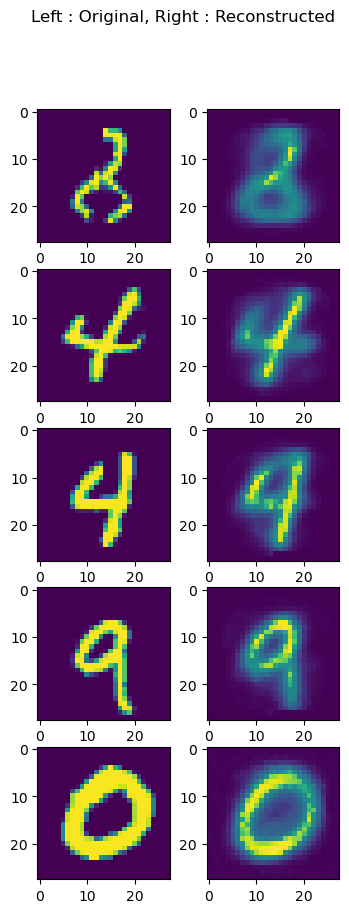

In [5]:
visualization(loader=test_loader, model=model, device=DEVICE, num_of_samples=5)

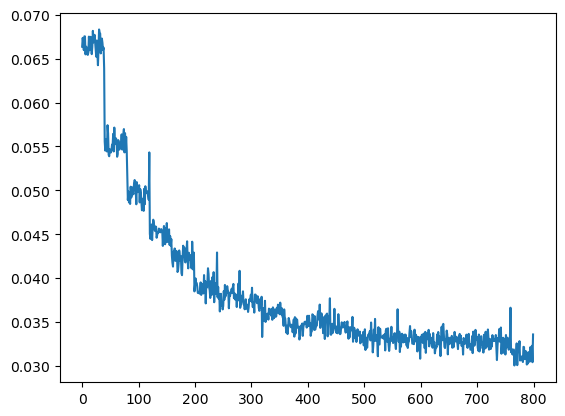

In [6]:
import numpy as np
plt.plot(np.array(test_loss))

In [5]:
encoder = nn.Sequential(
    nn.Conv2d(1,32,3, padding='same'),
    nn.ELU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32,64,3, padding='same'),
    nn.ELU(),
    nn.MaxPool2d(2)
)

decoder = nn.Sequential(
    nn.ConvTranspose2d(64, 32, 2, 2),
    nn.ReLU(),
    nn.ConvTranspose2d(32, 1, 2, 2),
    nn.Sigmoid()
)

In [13]:
conv_ae=Autoencoder(encoder=encoder, decoder=decoder).to(DEVICE)
criteria = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
train_loss, test_loss = autoencoder_trainer(model=model, 
                                            criteria=criteria, optimizer=optimizer, 
                                            train_loader=train_loader, test_loader=test_loader, 
                                            device=DEVICE, epochs = EPOCHS)

  5%|▌         | 1/20 [00:54<17:20, 54.75s/it]

epochs: 1 - Train error: 0.14040814340114594 - Test error: 0.1383497416973114


 10%|█         | 2/20 [01:50<16:35, 55.29s/it]

epochs: 2 - Train error: 0.1439434438943863 - Test error: 0.15350745618343353


 15%|█▌        | 3/20 [02:49<16:11, 57.12s/it]

epochs: 3 - Train error: 0.14528928697109222 - Test error: 0.1324864625930786


# Variational Autoencoder

In [15]:
model=VariationalAutoEncoder(n_hidden=256).to(DEVICE)
criteria = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [16]:
def vae_trainer(model, criteria, optimizer, train_loader, test_loader, device, epochs):
    train_loss = []
    test_loss = []
    for epoch in range(epochs):
        model.train()
        for x, _ in train_loader:
            x = x.to(device)
            _, mu, sigma, reconstruct = model(x)
            recon = torch.nn.functional.binary_cross_entropy(reconstruct, x, reduction='sum')
            #recon = torch.nn.functional.binary_cross_entropy(reconstruct, x)
            kl = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())
            print(f'train {sigma.mean():.5f}  {sigma.exp().mean():.5f} {mu.mean():.5f} {mu.pow(2).mean():.5f} {kl:.5f} | recon {recon}')
            loss = recon + kl
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        print(f'epochs: {epoch + 1} - Train recon: {recon:.2f} - Train KLD: {kl:.2f}')
        
        model.eval()
        for x, _ in test_loader:
            x = x.to(device)
            _, mu, sigma, reconstruct = model(x)
            recon = torch.nn.functional.binary_cross_entropy(reconstruct, x, reduction='sum')
            #recon = torch.nn.functional.binary_cross_entropy(reconstruct, x)
            kl = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())
            print(f'val {sigma.mean():.5f}  {sigma.exp().mean():.5f} {mu.mean():.5f} {mu.pow(2).mean():.5f} {kl:.5f} | recon {recon}')
            loss = recon + kl
            test_loss.append(loss.item())
            
        print(f'epochs: {epoch + 1} - Test recon: {recon:.2f} - Test KLD: {kl:.2f}')
    return train_loss, test_loss

In [17]:
train_loss, test_loss = vae_trainer(model=model, 
                              criteria=criteria, optimizer=optimizer, 
                              train_loader=train_loader, test_loader=test_loader, 
                              device=DEVICE, epochs = EPOCHS)

train 0.00155  1.00296 -0.00929 0.00357 12.74129
train 0.00059  1.00193 -0.00959 0.00354 12.48715
train 0.00029  1.00166 -0.00931 0.00343 12.26649
train -0.00015  1.00123 -0.00926 0.00351 12.51330
train -0.00047  1.00089 -0.00914 0.00341 12.18777
train -0.00083  1.00051 -0.00956 0.00338 12.08044
train -0.00104  1.00031 -0.00926 0.00330 11.89923
train -0.00180  0.99951 -0.00988 0.00326 11.70251
train -0.00205  0.99928 -0.00958 0.00328 11.80133
train -0.00234  0.99895 -0.01001 0.00324 11.61524
train -0.00354  0.99780 -0.01025 0.00326 11.77146
train -0.00311  0.99824 -0.01000 0.00325 11.78452
train -0.00381  0.99750 -0.01009 0.00320 11.55437
train -0.00469  0.99664 -0.00984 0.00317 11.53384
train -0.00494  0.99638 -0.00990 0.00308 11.27085
train -0.00535  0.99596 -0.00978 0.00309 11.26333
train -0.00629  0.99502 -0.00997 0.00308 11.21683
train -0.00612  0.99516 -0.01043 0.00306 11.10751
train -0.00637  0.99495 -0.00972 0.00304 11.16153
train -0.00709  0.99419 -0.01038 0.00299 10.93161
tra

In [12]:
a[-1].max()

NameError: name 'a' is not defined

In [13]:
for i in train_loader:
    a = model(i[0][0].unsqueeze(0).to(DEVICE))
    print(a)
    break

(tensor([[-0.7918,  0.4327,  1.9738, -2.1838, -0.3047,  0.7721,  0.0818, -0.2800,
         -0.1338,  1.1409,  1.7621, -0.4323, -1.0628,  0.6620,  0.1919, -1.7975,
          0.2100, -2.2577, -0.2146,  0.1501]], device='cuda:0',
       grad_fn=<AddBackward0>), tensor([[-0.0071,  0.0064,  0.0062, -0.0072, -0.0042,  0.0063, -0.0044,  0.0016,
         -0.0013, -0.0026, -0.0016,  0.0028,  0.0009,  0.0019,  0.0003, -0.0024,
         -0.0040, -0.0118,  0.0008, -0.0003]], device='cuda:0',
       grad_fn=<AddmmBackward0>), tensor([[0.0341, 0.0347, 0.0322, 0.0290, 0.0292, 0.0315, 0.0316, 0.0324, 0.0324,
         0.0279, 0.0279, 0.0300, 0.0327, 0.0298, 0.0317, 0.0346, 0.0331, 0.0322,
         0.0356, 0.0351]], device='cuda:0', grad_fn=<AddmmBackward0>), tensor([[6.6302e-05, 6.1623e-05, 5.0498e-05, 6.6059e-05, 6.8160e-05, 7.8363e-05,
         7.5826e-05, 1.0577e-04, 7.9006e-05, 8.0449e-05, 7.4763e-05, 6.3537e-05,
         1.0002e-04, 6.6060e-05, 5.8384e-05, 9.6209e-05, 7.8987e-05, 7.5138e-05,
     

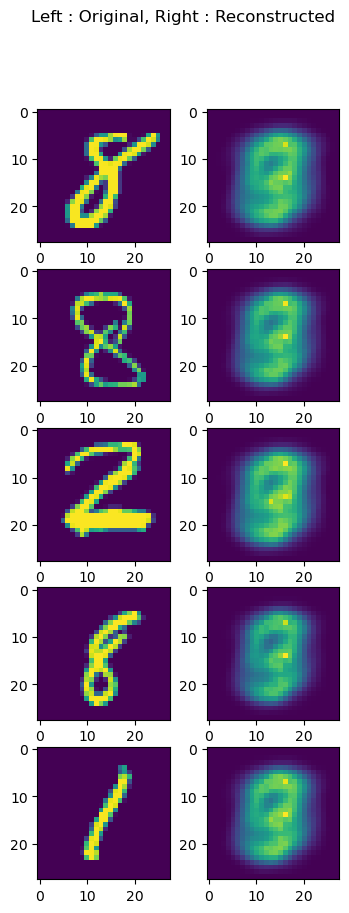

In [14]:
visualization(loader=test_loader, model=model, device=DEVICE, num_of_samples=5)